In [1]:
# load the model first, run the evaluator on the model.

import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_performance

from models.utils import get_model_size_in_MB
from models.build import create_model_from_setup
from models.setup import ModelSetup
from models.train import TrainingInfo
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_ap_ar, get_ap_ar_for_train_val
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss
from utils.init import reproducibility, clean_memory_get_device
from data.paths import MIMIC_EYE_PATH
# from datetime import datetime
# from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim
from data.paths import MIMIC_EYE_PATH
from models.load import get_trained_model
# from data.load import seed_worker, get_dataloader_g
from utils.plot import DISEASE_CMAP, get_legend_elements
legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from enum import Enum

class TrainedModels(Enum):
    mobilenet_baseline = "val_lesion-detection_ap_0_1655_test_lesion-detection_ap_0_1648_epoch50_03-15-2023 16-43-54_lesion_dsetection_baseline_mobilenet"  # mobilenet baseline
    mobilenet_with_fix = "val_lesion-detection_ap_0_1918_test_lesion-detection_ap_0_1903_epoch16_03-16-2023 11-34-10_lesion_dsetection_with_fixation_mobilenet"
    resnet18_baseline = "val_lesion-detection_ap_0_1973_test_lesion-detection_ap_0_2010_epoch22_03-16-2023 19-44-55_lesion_dsetection_baseline_resnet"
    resnet18_with_fix = "val_lesion-detection_ap_0_1951_test_lesion-detection_ap_0_2195_epoch12_03-17-2023 00-31-54_lesion_dsetection_with_fixation_resnet"
    densenet161_baseline = "val_lesion-detection_ap_0_1990_test_lesion-detection_ap_0_2085_epoch5_03-17-2023 08-53-33_lesion_dsetection_baseline_densenet161"
    densenet161_with_fix = "val_lesion-detection_ap_0_2120_test_lesion-detection_ap_0_2104_epoch12_03-17-2023 18-36-01_lesion_dsetection_with_fixation_densenet161"
    efficientnet_b5_baseline = "val_lesion-detection_ap_0_1898_test_lesion-detection_ap_0_2055_epoch5_03-17-2023 23-30-57_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b5_with_fix = "val_lesion-detection_ap_0_2117_test_lesion-detection_ap_0_2190_epoch8_03-18-2023 12-29-20_lesion_dsetection_with_fixation_efficientnet_b5"
    efficientnet_b0_baseline = "val_lesion-detection_ap_0_1934_test_lesion-detection_ap_0_1858_epoch10_03-18-2023 23-50-47_lesion_dsetection_baseline_efficientnet_b0"
    efficientnet_b0_with_fix = "val_lesion-detection_ap_0_2191_test_lesion-detection_ap_0_2162_epoch10_03-18-2023 19-38-11_lesion_dsetection_with_fixation_efficientnet_b0"
    convnext_base_with_fix = "val_lesion-detection_ap_0_2610_test_lesion-detection_ap_0_2548_epoch22_03-22-2023 02-55-37_lesion_dsetection_with_fixation_convnext_base"
    convnext_base_baseline = "val_lesion-detection_ap_0_2426_test_lesion-detection_ap_0_2325_epoch20_03-22-2023 11-53-53_lesion_dsetection_baseline_convnext_base"
    vgg16_with_fix = "val_lesion-detection_ap_0_2301_test_lesion-detection_ap_0_2186_epoch22_03-20-2023 19-26-02_lesion_dsetection_with_fixation_vgg16"
    vgg16_baseline = "val_lesion-detection_ap_0_2113_test_lesion-detection_ap_0_2068_epoch12_03-21-2023 00-45-24_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix = "val_lesion-detection_ap_0_2267_test_lesion-detection_ap_0_2029_epoch12_03-21-2023 11-28-48_lesion_dsetection_with_fixation_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_ap_0_1883_test_lesion-detection_ap_0_1658_epoch13_03-21-2023 15-22-32_lesion_dsetection_baseline_regnet_y_8gf"

In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
get_epoch_from_model = lambda select_model: int(([substr for substr in select_model.value.split("_") if "epoch" in substr][0]).replace("epoch", ""))
get_model_name = lambda select_model: str(select_model).split(".")[-1]

In [5]:
select_model = TrainedModels.densenet161_with_fix

In [6]:
model, train_info, optimizer, dynamic_loss_weight = get_trained_model(
        select_model,
        device,
    )

model.to(device)

# setting up the score threshold to 0 for froc.
model.task_performers['lesion-detection'].roi_heads.score_thresh = 0
model.eval()

# cover the long model.
print()

Using pretrained backbone. densenet161
Using pretrained backbone. densenet161
Using SGD as optimizer with lr=0.01



In [7]:
setup = train_info.model_setup
iou_types = get_iou_types(model, setup)

In [8]:
from data.strs import SourceStrs, TaskStrs

dataset_params_dict = {
        "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
        "labels_cols": setup.lesion_label_cols,
        "with_xrays_input": SourceStrs.XRAYS in setup.sources,
        "with_clincal_input": SourceStrs.CLINICAL in setup.sources,
        "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
        "fixations_mode_input": setup.fiaxtions_mode_input,
        "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
        "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
        "fixations_mode_label": setup.fiaxtions_mode_label,
        "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
        "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
        "clinical_numerical_cols": setup.clinical_num,
        "clinical_categorical_cols": setup.clinical_cat,
        "image_size": setup.image_size,
        "image_mean": setup.image_mean,
        "image_std": setup.image_std,
    }

In [9]:
detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=setup.batch_size,
)

train_coco = None
train_coco, val_coco, test_coco, eval_dict = get_coco_eval_params(
    source_name=SourceStrs.XRAYS,
    task_name=TaskStrs.LESION_DETECTION,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    detect_eval_dataset=detect_eval_dataset,
    iou_thrs=np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]),
    use_iobb=setup.use_iobb,
    maxDets=[1, 5, 10, 30],
)

In [10]:
test_evaluator, _, (dts, eval_gts) = evaluate(
    setup=setup,
    model=model,
    data_loader=test_dataloader,
    device=device,
    params_dict=eval_dict,
    coco=test_coco,
    iou_types=iou_types,
    return_dt_gt=True,
)

Evaluation:  [ 0/57]  eta: 0:03:44  loss: 0.3649 (0.3649)  lesion-detection_performer-object_detection_loss_classifier: 0.1999 (0.1999)  lesion-detection_performer-object_detection_loss_box_reg: 0.1117 (0.1117)  lesion-detection_performer-object_detection_loss_objectness: 0.0490 (0.0490)  lesion-detection_performer-object_detection_loss_rpn_box_reg: 0.0043 (0.0043)  model_time: 1680200448.0000 (1680200409.8738)  evaluator_time: 0.0000 (0.0000)  time: 3.9412  data: 2.0082  max mem: 1137
Evaluation:  [56/57]  eta: 0:00:02  loss: 0.2141 (0.2027)  lesion-detection_performer-object_detection_loss_classifier: 0.1060 (0.1041)  lesion-detection_performer-object_detection_loss_box_reg: 0.0781 (0.0697)  lesion-detection_performer-object_detection_loss_objectness: 0.0244 (0.0253)  lesion-detection_performer-object_detection_loss_rpn_box_reg: 0.0038 (0.0036)  model_time: 1680200576.0000 (1680200476.9500)  evaluator_time: 0.0000 (0.0000)  time: 2.3697  data: 2.0807  max mem: 1139
Evaluation: Total 

In [11]:
# import itertools
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# from coco_froc_analysis.froc.froc_curve import froc_point, calc_scores
# from coco_froc_analysis.utils import  update_scores, build_gt_id2annotations, build_pr_id2annotations
# from coco_froc_analysis.froc.froc_stats import update_stats, init_stats

In [22]:
import itertools
from scipy import interpolate

def get_froc(dts, eval_gts,  fps_per_img = [0.5, 1, 2, 4], cat_id = -1):
    anns = []
    gts = [g['lesion-detection'] for g in list(itertools.chain.from_iterable(list(eval_gts)))]
    for g in gts:
        for i, bb in enumerate(g['unsized_boxes']):
            anns.append({
                "image_id": g['image_id'].item(),
                "category_id": g['labels'][i].item(),
                "iscrowd": g["iscrowd"][i].item(),
                "bbox": bb.tolist(),
                "ignore": 0, 
            })

    pr = []
    for dt in dts:
        for image_id, d in dt.items():
            for i in range(len(d['boxes'])):
                pr.append({
                    "image_id": image_id,
                    "category_id":d["labels"][i].item(),
                    "score": d["scores"][i].item(),
                    "bbox": d['boxes'][i].numpy().tolist()
                })   

    categories = [
        {
            "id": test_dataset.disease_to_idx(i),
            "name" : i,
            "color": "blue",
        } for i in test_dataset.labels_cols
    ]

    gt = {
        "categories": categories,
        "annotations": anns,
        "images": [{"id": id}  for id in list(set([g['image_id'].item()  for g in gts]))]
    }

    from coco_froc_analysis.froc.froc_curve import generate_froc_curve

    lls_accuracy,nlls_per_image= generate_froc_curve(
        gt=gt,
        pr=pr,
        use_iou=False,
        iou_thres=0.5,
        n_sample_points=100,
        plot_title=None,
        plot_output_path='froc.png',
        bounds=None,
    )

    f = interpolate.interp1d(nlls_per_image[cat_id], lls_accuracy[cat_id], fill_value='extrapolate')

    return f(fps_per_img)


In [25]:
froc_v = get_froc(dts=dts, eval_gts=eval_gts, fps_per_img=[0.5, 1, 2, 4], cat_id=5)

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
froc_v.mean()

0.750091145156536

In [24]:
froc_v.mean()

0.7217340422943803

In [12]:
# anns = []
# gts = [g['lesion-detection'] for g in list(itertools.chain.from_iterable(list(eval_gts)))]
# for g in gts:
#     for i, bb in enumerate(g['unsized_boxes']):
#         anns.append({
#             "image_id": g['image_id'].item(),
#             "category_id": g['labels'][i].item(),
#             "iscrowd": g["iscrowd"][i].item(),
#             "bbox": bb.tolist(),
#             "ignore": 0, 
#         })

# pr = []
# for dt in dts:
#     for image_id, d in dt.items():
#         for i in range(len(d['boxes'])):
#             pr.append({
#                 "image_id": image_id,
#                 "category_id":d["labels"][i].item(),
#                 "score": d["scores"][i].item(),
#                 "bbox": d['boxes'][i].numpy().tolist()
#             })   

# categories = [
#     {
#         "id": test_dataset.disease_to_idx(i),
#         "name" : i,
#         "color": "blue",
#     } for i in test_dataset.labels_cols
# ]

# gt = {
#     "categories": categories,
#     "annotations": anns,
#     "images": [{"id": id}  for id in list(set([g['image_id'].item()  for g in gts]))]
# }



  0%|          | 0/100 [00:00<?, ?it/s]

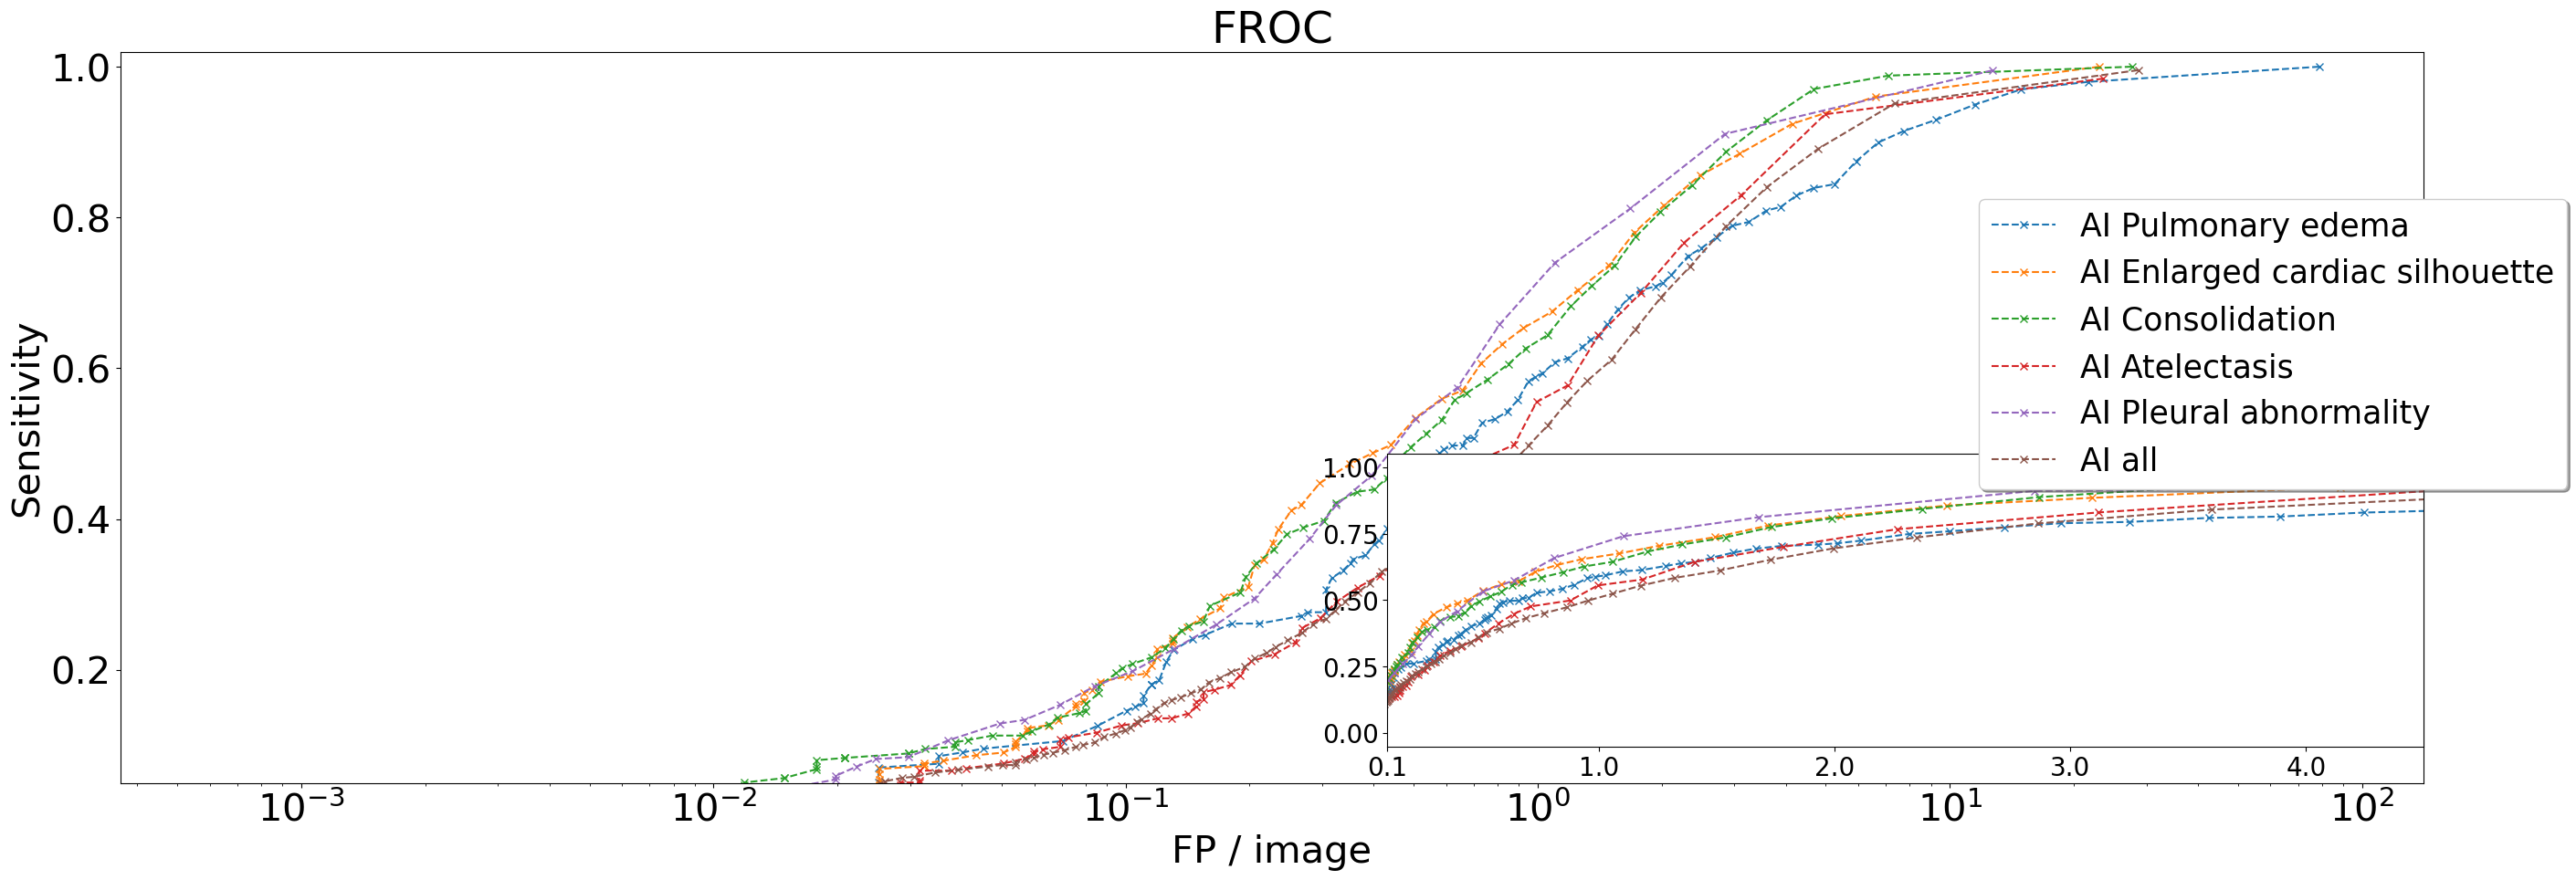

array([0.36660972, 0.50986744, 0.69509533, 0.85734694])

In [ ]:


def sens_at_FP( boxes_all, gts_all, avgFP, iou_th):
    # compute the sensitivity at avgFP (average FP per image)
    sens, fp_per_img, sorted_scores = FROC(boxes_all, gts_all, iou_th)
    max_fp = fp_per_img[-1]
    f = interpolate.interp1d(fp_per_img, sens, fill_value='extrapolate')
    s = interpolate.interp1d(sens, sorted_scores, fill_value='extrapolate')
    if(avgFP[-1] < max_fp):
        valid_avgFP_end_idx = len(avgFP)
    else:
        valid_avgFP_end_idx = np.argwhere(np.array(avgFP) > max_fp)[0][0]
    valid_avgFP = np.hstack((avgFP[:valid_avgFP_end_idx], max_fp))
    print(valid_avgFP)
    res = f(valid_avgFP)
    score_thresh = s(res)
    return res,valid_avgFP, score_thresh

In [19]:
all_image_ids = set([i['image_id'].item()  for i in gts])

In [20]:
categories = [
    {
        "id": test_dataset.disease_to_idx(i),
        "name" : i,
        "color": "blue",
    } for i in test_dataset.labels_cols
]


# all_boxes = {}
# for cls in test_dataset.labels_cols:
#     disease_idx =  test_dataset.disease_to_idx(cls)
#     all_boxes[disease_idx] = {}
#     for image_id in all_image_ids:
#         all_boxes[disease_idx][image_id] = []

all_boxes = [[ np.empty((0,5), dtype=np.float32) for  image_id in all_image_ids  ]   for cls in ['background'] + test_dataset.labels_cols ]
# all_boxes = {{ test_dataset.disease_to_idx(cls)  : { image_id: [] for image_id in all_image_ids}}  for cls in test_dataset.labels_cols}

In [21]:
for dt in dts:
    for image_id, d in dt.items():
        for i in range(len(d['boxes'])):
            coord_score = d['boxes'][i].numpy().tolist() + [ d["scores"][i].item()]
            all_boxes[d["labels"][i].item()][image_id] = np.concatenate([all_boxes[d["labels"][i].item()][image_id],np.array(coord_score)[np.newaxis, :]], axis=0)
            # all_boxes[d["labels"][i].item()][image_id].append(coord_score)

In [22]:
gt_boxes = [[ np.empty((0,4), dtype=np.float32) for  image_id in all_image_ids  ]   for cls in ['background'] +test_dataset.labels_cols ]
# for cls in test_dataset.labels_cols:
#     disease_idx = test_dataset.disease_to_idx(cls)

#     gt_boxes[disease_idx] = {}
#     for image_id in all_image_ids:
#         gt_boxes[disease_idx][image_id] = []

In [23]:
for ann in anns:
    # gt_boxes[ann['category_id']][ann['image_id']].append(ann['bbox'])
    gt_boxes[ann['category_id']][ann['image_id']] = np.concatenate([gt_boxes[ann['category_id']][ann['image_id']],np.array(ann['bbox'])[np.newaxis, :]], axis=0)


In [24]:
class AllClass():
    nHits = 0
    nMiss = 0
    tps = []
    fps = []
    no_lesion = 0
    nGt = 0
    nImg = 0
    sorted_scores = []

In [25]:
pr_id_to_annotation = build_pr_id2annotations(pr)

In [26]:
gt_id_to_annotation =  build_gt_id2annotations(gt)

In [38]:
gt_id_to_annotation

{0: [{'image_id': 0,
   'category_id': 2,
   'iscrowd': 0,
   'bbox': [831.0, 1204.0, 2223.0, 2310.0],
   'ignore': 0}],
 1: [],
 2: [{'image_id': 2,
   'category_id': 4,
   'iscrowd': 0,
   'bbox': [2320.0, 1755.0, 2781.0, 2179.0],
   'ignore': 0}],
 3: [{'image_id': 3,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [508.0, 1404.0, 1219.0, 1897.0],
   'ignore': 0},
  {'image_id': 3,
   'category_id': 2,
   'iscrowd': 0,
   'bbox': [508.0, 1404.0, 1219.0, 1897.0],
   'ignore': 0},
  {'image_id': 3,
   'category_id': 3,
   'iscrowd': 0,
   'bbox': [508.0, 1404.0, 1219.0, 1897.0],
   'ignore': 0},
  {'image_id': 3,
   'category_id': 4,
   'iscrowd': 0,
   'bbox': [508.0, 1404.0, 1219.0, 1897.0],
   'ignore': 0},
  {'image_id': 3,
   'category_id': 5,
   'iscrowd': 0,
   'bbox': [508.0, 1404.0, 1219.0, 1897.0],
   'ignore': 0},
  {'image_id': 3,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [1015.0, 977.0, 2659.0, 1967.0],
   'ignore': 0},
  {'image_id': 3,
   'category_id': 2,
   'i

In [49]:
sorted_pr[0]

{'image_id': 138,
 'category_id': 1,
 'score': 0.9437191486358643,
 'bbox': [688.3878784179688,
  1240.6702880859375,
  2462.95166015625,
  2123.00390625]}

In [50]:
anns[0]

{'image_id': 378,
 'category_id': 3,
 'iscrowd': 0,
 'bbox': [243.0, 1282.0, 678.0, 1632.0],
 'ignore': 0}

In [48]:
# sorted_pr, anns

In [29]:
def IOU(box1, gts):
    # compute overlaps
    # intersection
    ixmin = np.maximum(gts[:, 0], box1[0])
    iymin = np.maximum(gts[:, 1], box1[1])
    ixmax = np.minimum(gts[:, 2], box1[2])
    iymax = np.minimum(gts[:, 3], box1[3])
    iw = np.maximum(ixmax - ixmin, 0.)
    ih = np.maximum(iymax - iymin, 0.)
    inters = iw * ih

    # union
    uni = ((box1[2] - box1[0]) * (box1[3] - box1[1]) +
            (gts[:, 2] - gts[:, 0]) *
            (gts[:, 3] - gts[:, 1]) - inters)

    overlaps = inters / uni
    # ovmax = np.max(overlaps)
    # jmax = np.argmax(overlaps)
    return overlaps

In [30]:
def All_class_FROC( boxes_all, gts_all, iou_th):
    # Compute the FROC curve, for single class only
    nImg = len(boxes_all) # (#img, #bb)?
    # img_idxs_ori : array([   0.,    0.,    0., ..., 4830., 4830., 4830.])


    # has to be sorted by the score.
    img_idxs_ori = np.hstack([[i]*len(boxes_all[i]) for i in range(nImg)]).astype(int)
    boxes_cat = np.vstack(boxes_all)
    scores = boxes_cat[:, -1]
    ord = np.argsort(scores)[::-1]
    sorted_scores = scores[ord]
    boxes_cat = boxes_cat[ord, :4] # what's the cat for? it's not coordinate?
    img_idxs = img_idxs_ori[ord] 

    hits = [np.zeros((len(gts),), dtype=bool) for gts in gts_all]
    nHits = 0
    nMiss = 0
    tps = []
    fps = []
    no_lesion = 0
    for i in range(len(boxes_cat)):
        overlaps = IOU(boxes_cat[i, :], gts_all[img_idxs[i]])
        if overlaps.shape[0] == 0:
            no_lesion += 1
            nMiss += 1

            AllClass.no_lesion += 1
            AllClass.nMiss += 1
        elif overlaps.max() < iou_th:
            nMiss += 1
            AllClass.nMiss += 1
        else:
            for j in range(len(overlaps)):
                if overlaps[j] >= iou_th and not hits[img_idxs[i]][j]:
                    hits[img_idxs[i]][j] = True
                    nHits += 1
                    AllClass.nHits += 1

        tps.append(nHits)
        fps.append(nMiss)

        AllClass.tps.append(AllClass.nHits)
        AllClass.fps.append(AllClass.nMiss)
    nGt = len(np.vstack(gts_all))
    AllClass.nGt += nGt
    sens = np.array(tps, dtype=float) / nGt
    fp_per_img = np.array(fps, dtype=float) / nImg # array(list) / int

    print(f"Hit: {nHits}, Miss: {nMiss}, nGt: {nGt}, fp_per_img: {fp_per_img[-1]}")

    AllClass.nImg += nImg
    print('FROC:FP in no-lesion-images: ', no_lesion)

    AllClass.sorted_scores.append(sorted_scores)
    return sens, fp_per_img, sorted_scores

In [31]:
def FROC( boxes_all, gts_all, iou_th):
    # Compute the FROC curve, for single class only
    nImg = len(boxes_all) # (#img, #bb)?
    # img_idxs_ori : array([   0.,    0.,    0., ..., 4830., 4830., 4830.])
    img_idxs_ori = np.hstack([[i]*len(boxes_all[i]) for i in range(nImg)]).astype(int)
    boxes_cat = np.vstack(boxes_all)
    scores = boxes_cat[:, -1]
    ord = np.argsort(scores)[::-1]
    sorted_scores = scores[ord]
    boxes_cat = boxes_cat[ord, :4] # what's the cat for? it's not coordinate?
    img_idxs = img_idxs_ori[ord] 

    hits = [np.zeros((len(gts),), dtype=bool) for gts in gts_all]
    nHits = 0
    nMiss = 0
    tps = []
    fps = []
    no_lesion = 0
    for i in range(len(boxes_cat)):
        overlaps = IOU(boxes_cat[i, :], gts_all[img_idxs[i]])
        if overlaps.shape[0] == 0:
            no_lesion += 1
            nMiss += 1

            AllClass.no_lesion += 1
            AllClass.nMiss += 1
        elif overlaps.max() < iou_th:
            nMiss += 1
            AllClass.nMiss += 1
        else:
            for j in range(len(overlaps)):
                if overlaps[j] >= iou_th and not hits[img_idxs[i]][j]:
                    hits[img_idxs[i]][j] = True
                    nHits += 1
                    AllClass.nHits += 1

        tps.append(nHits)
        fps.append(nMiss)

        AllClass.tps.append(AllClass.nHits)
        AllClass.fps.append(AllClass.nMiss)
    nGt = len(np.vstack(gts_all))
    AllClass.nGt += nGt
    sens = np.array(tps, dtype=float) / nGt
    fp_per_img = np.array(fps, dtype=float) / nImg # array(list) / int

    print(f"Hit: {nHits}, Miss: {nMiss}, nGt: {nGt}, fp_per_img: {fp_per_img[-1]}")

    AllClass.nImg += nImg
    print('FROC:FP in no-lesion-images: ', no_lesion)

    AllClass.sorted_scores.append(sorted_scores)
    return sens, fp_per_img, sorted_scores

In [32]:
from scipy import interpolate

def sens_at_FP( boxes_all, gts_all, avgFP, iou_th):
    # compute the sensitivity at avgFP (average FP per image)
    sens, fp_per_img, sorted_scores = FROC(boxes_all, gts_all, iou_th)
    max_fp = fp_per_img[-1]
    f = interpolate.interp1d(fp_per_img, sens, fill_value='extrapolate')
    s = interpolate.interp1d(sens, sorted_scores, fill_value='extrapolate')
    if(avgFP[-1] < max_fp):
        valid_avgFP_end_idx = len(avgFP)
    else:
        valid_avgFP_end_idx = np.argwhere(np.array(avgFP) > max_fp)[0][0]
    valid_avgFP = np.hstack((avgFP[:valid_avgFP_end_idx], max_fp))
    print(valid_avgFP)
    res = f(valid_avgFP)
    score_thresh = s(res)
    return res,valid_avgFP, score_thresh

In [33]:
def eval_FROC( input_all_boxes, input_gt_boxes, avgFP=[0.05, 0.1, 0.2, 0.5,1,2,3,4,8,16,32,64], iou_th=0.5):
    # all_boxes[cls][image] = N x 5 array with columns (x1, y1, x2, y2, score)
    # only one class for lesion dataset.
    # all_boxes[1][image] = N X 5
    recall_per_class = [['0.0','-'] for i in range(1, len(input_all_boxes))]
    print('len all_boxes',len(input_all_boxes))
    for cls in range(0, len(input_all_boxes)):
        print(cls)
        if cls == 0:
            # it's the background
            continue

        all_boxes, gt_boxes = input_all_boxes[cls], input_gt_boxes[cls]
        result, valid_avgFP, score_thresh = sens_at_FP(all_boxes, gt_boxes, avgFP, iou_th)
        print('='*20, 'cls:%s'%cls, '='*20)
        for idx, recall in enumerate(result[:2]):
            recall_per_class[cls-1][idx] = str(recall*100)[:4]
        for recall,fp, score in zip(result,valid_avgFP, score_thresh):
            print('Recall@%.2f=%.2f%%, score_threshold=%.4f' % (fp, recall*100, score))
        #TODO: when num of valid_avgFP < 6,is FROC correct?
        print('Mean FROC is %.2f'% np.mean(np.array(result[:len(avgFP)])*100))
    print('='*47)
    return recall_per_class

In [34]:
recall_per_calss = eval_FROC( np.array(all_boxes), np.array(gt_boxes), avgFP=[0.5,1,2,4], iou_th=0.5)

len all_boxes 6
0
1
Hit: 128, Miss: 1556, nGt: 199, fp_per_img: 3.4197802197802196
FROC:FP in no-lesion-images:  1133
[0.5        1.         2.         3.41978022]
==================== cls:1 ====================
Recall@0.50=35.68%, score_threshold=0.3229
Recall@1.00=45.73%, score_threshold=0.1883
Recall@2.00=56.78%, score_threshold=0.0979
Recall@3.42=64.32%, score_threshold=0.0505
Mean FROC is 50.63
2
Hit: 145, Miss: 626, nGt: 277, fp_per_img: 1.3758241758241758
FROC:FP in no-lesion-images:  388
[0.5        1.         1.37582418]
==================== cls:2 ====================
Recall@0.50=35.02%, score_threshold=0.1372
Recall@1.00=42.60%, score_threshold=0.0742
Recall@1.38=52.35%, score_threshold=0.0507
Mean FROC is 43.32
3
Hit: 156, Miss: 895, nGt: 337, fp_per_img: 1.967032967032967
FROC:FP in no-lesion-images:  492
[0.5        1.         1.96703297]
==================== cls:3 ====================
Recall@0.50=22.85%, score_threshold=0.2081
Recall@1.00=34.12%, score_threshold=0.1112
Re

In [36]:
avgFP= [0.5,1,2,4]
# avgFP= [0.05, 0.1, 0.2, 0.5,1,2,3,4,8,16,32,64]
sens = np.array(AllClass.tps)/ AllClass.nGt
fp_per_img = np.array(AllClass.fps, dtype=float)/ AllClass.nImg
sorted_scores = np.concatenate(AllClass.sorted_scores, axis=0)
ord = np.argsort(sorted_scores)[::-1]
sorted_scores = sorted_scores[ord]

max_fp = fp_per_img[-1]

f = interpolate.interp1d(fp_per_img, sens, fill_value='extrapolate')
s = interpolate.interp1d(sens, sorted_scores, fill_value='extrapolate')


if(avgFP[-1] < max_fp):
    valid_avgFP_end_idx = len(avgFP)
else:
    valid_avgFP_end_idx = np.argwhere(np.array(avgFP) > max_fp)[0][0]
valid_avgFP = np.hstack((avgFP[:valid_avgFP_end_idx], max_fp))
print(valid_avgFP)
res = f(valid_avgFP)
score_thresh = s(res)

print('='*20, 'cls:all', '='*20)
# for idx, recall in enumerate(result[:2]):
#     recall_per_class[cls-1][idx] = str(recall*100)[:4]
for recall,fp, score in zip(res,valid_avgFP, score_thresh):
    print('Recall@%.2f=%.2f%%, score_threshold=%.4f' % (fp, recall*100, score))
#TODO: when num of valid_avgFP < 6,is FROC correct?
print('Mean FROC is %.2f'% np.mean(np.array(res[:len(avgFP)])*100))

[0.5        1.         1.74769231]
==================== cls:all ====================
Recall@0.50=7.63%, score_threshold=0.1931
Recall@1.00=21.12%, score_threshold=0.1010
Recall@1.75=41.13%, score_threshold=0.0500
Mean FROC is 23.29


In [37]:
fp_per_img[-1]

1.7476923076923077

In [ ]:
AllClass.fps[-1]/AllClass.nImg

19.271648351648352

In [ ]:
sens[-1]

0.6942633637548892